In [1]:
# 解压数据集
!unzip /home/aistudio/data/data322679/train_part.zip -d  /home/aistudio/train_part

  inflating: /home/aistudio/train_part/game_5/frames/frame_070712.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_070713.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_070714.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_070715.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_070716.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_070717.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_070718.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_072153.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_072154.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_072155.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_072156.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_072157.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_072158.png  
  inflating: /home/aistudio/train_part/game_5/frames/frame_07215

In [12]:
# 安装paddledetection，2.6可能不行
!git clone https://gitee.com/paddlepaddle/PaddleDetection.git
!cd PaddleDetection
!git checkout release/2.6  # 切换到稳定分支
!pip install -r /home/aistudio/PaddleDetection/requirements.txt
!python /home/aistudio/PaddleDetection/setup.py install

ModuleNotFoundError: No module named '__init__'

In [2]:
# 将数据集转化为coco格式
# 如果ball position不存在（-1，-1），那就跳过
# 乒乓球大小大概为25x25，包含模糊面积
import os
import json
from PIL import Image

# 数据集根目录
root_dir = r"/home/aistudio/train_part"
# 要处理的子文件夹列表
games = [f"game_{i}" for i in range(5, 6)]

# COCO数据结构初始化
coco = {
    "images": [],
    "annotations": [],
    "categories": [
        {
            "id": 1,
            "name": "ball",
            "supercategory": "ball",
            "keypoints": ["ball_center"],
            "skeleton": []
        }
    ]
}

image_id = 1
ann_id = 1

# 遍历每个游戏文件夹
for game in games:
    game_dir = os.path.join(root_dir, game)
    ann_path = os.path.join(game_dir, "annotations.json")
    frames_dir = os.path.join(game_dir, "frames")
    
    # 加载 annotations.json
    with open(ann_path, "r", encoding="utf-8") as f:
        annotations = json.load(f)
    
    # 遍历每个注释
    for key, ann in annotations.items():
        # 根据 key 生成对应图像文件名
        frame_filename = f"frame_{int(key):06d}.png"
        frame_path = os.path.join(frames_dir, frame_filename)
        
        # 如果文件不存在，可以根据实际情况调整命名规则
        if not os.path.exists(frame_path):
            print(f"警告：找不到文件 {frame_path}")
            continue
        
        # 读取图像尺寸
        with Image.open(frame_path) as img:
            width, height = img.size
        
        # 添加 image 条目
        coco["images"].append({
            "id": image_id,
            "file_name": os.path.join(game, "frames", frame_filename).replace("\\", "/"),
            "width": width,
            "height": height
        })
        
        # 检查 ball_position 键是否存在
        if "ball_position" not in ann:
            print(f"警告：注释 {key} 中不存在 'ball_position' 键，跳过该记录。")
            image_id += 1  # 图片ID递增，保持图片与标注一一对应
            continue
        
        # 获取球的位置
        ball_x = ann["ball_position"]["x"]
        ball_y = ann["ball_position"]["y"]
        # 这里构造一个 1x1 的bbox，格式为 [x, y, width, height]
        bbox = [ball_x, ball_y, 25, 25]
        # 构造 keypoints：[x, y, visibility]
        keypoints = [ball_x, ball_y, 2]
        # 根据 event 判断是否为弹起帧
        is_bounce = 1 if ann.get("event") == "bounce" else 0
        
        # 添加 annotation 条目
        coco["annotations"].append({
            "id": ann_id,
            "image_id": image_id,
            "category_id": 1,
            "bbox": bbox,
            "area": 1,
            "iscrowd": 0,
            "keypoints": keypoints,
            "attributes": {
                "is_bounce": is_bounce
            }
        })
        
        image_id += 1
        ann_id += 1

# 将生成的COCO格式数据写入json文件
output_path = os.path.join(root_dir, "coco_annotations.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(coco, f, indent=4, ensure_ascii=False)

print(f"转换完成，COCO标注文件保存在：{output_path}")


转换完成，COCO标注文件保存在：/home/aistudio/train_part/coco_annotations.json


In [2]:
# 安装所需依赖
!pip install pycocotools
# 导入package
!pip install -r ~/PaddleDetection/requirements.txt


Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 16.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 6.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 456.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 585.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 6.8 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.0 MB/s eta 0:00:00ta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.

In [ ]:
# 训练
%cd /home/aistudio/PaddleDetection
!python tools/train.py -c configs/smalldet/ppyoloe_plus_sod_crn_l_80e_coco.yml --amp --eval --use_vdl True --vdl_log_dir vdl_log_dir/scalar


[04/08 13:21:29] ppdet.engine.callbacks INFO: Epoch: [71] [251/264] learning_rate: 0.000020 loss: 0.971293 loss_cls: 0.463778 loss_iou: 0.101165 loss_dfl: 0.509207 loss_l1: 2.554764 eta: 1:37:36 batch_cost: 0.3410 data_cost: 0.0010 ips: 82.1096 images/s, max_mem_reserved: 30648 MB, max_mem_allocated: 27449 MB
[04/08 13:21:38] ppdet.engine.callbacks INFO: Epoch: [71] [252/264] learning_rate: 0.000020 loss: 0.879948 loss_cls: 0.427887 loss_iou: 0.079726 loss_dfl: 0.505493 loss_l1: 2.004758 eta: 1:37:34 batch_cost: 8.6030 data_cost: 8.0977 ips: 3.2547 images/s, max_mem_reserved: 30648 MB, max_mem_allocated: 27449 MB
[04/08 13:21:38] ppdet.engine.callbacks INFO: Epoch: [71] [253/264] learning_rate: 0.000020 loss: 0.911527 loss_cls: 0.437816 loss_iou: 0.085894 loss_dfl: 0.517953 loss_l1: 1.886783 eta: 1:37:31 batch_cost: 0.6424 data_cost: 0.0009 ips: 43.5832 images/s, max_mem_reserved: 30648 MB, max_mem_allocated: 27449 MB
[04/08 13:21:39] ppdet.engine.callbacks INFO: Epoch: [71] [254/264] 

In [4]:
# 评估
%cd /home/aistudio/PaddleDetection
!python tools/eval.py -c configs/smalldet/ppyoloe_plus_sod_crn_l_80e_coco.yml -o weights=output/best_model.pdparams


/home/aistudio/PaddleDetection
[04/08 18:38:43] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
W0408 18:38:43.769464 12119 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0408 18:38:43.771142 12119 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[04/08 18:38:48] ppdet.data.source.coco INFO: Load [7406 samples valid, 0 samples invalid] in file /home/aistudio/train_part/coco_annotations.json.
[04/08 18:38:52] ppdet.utils.checkpoint INFO: Finish loading model weights: output/best_model.pdparams
[04/08 18:39:06] ppdet.engine.callbacks INFO: Eval iter: 0
[04/08 18:42:47] ppdet.engine.callbacks INFO: Eval iter: 100
[04/08 18:43:29] ppdet.metrics.metrics INFO: The bbox result is saved to bbox.json.
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
[04/08 18:43:31] ppdet.m

In [4]:
# 预测
%cd /home/aistudio/PaddleDetection
!python tools/infer.py -c configs/smalldet/ppyoloe_plus_sod_crn_l_80e_coco.yml -o weights=output/best_model.pdparams --infer_dir=/home/aistudio/train_part/game_3/frames/frame_003391.png --output_dir infer_output/


/home/aistudio/PaddleDetection
[04/14 17:49:34] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
W0414 17:49:35.103839  5326 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0414 17:49:35.105219  5326 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.
[04/14 17:49:43] ppdet.utils.checkpoint INFO: Finish loading model weights: output/best_model.pdparams
Traceback (most recent call last):
  File "/home/aistudio/PaddleDetection/tools/infer.py", line 280, in <module>
    main()
  File "/home/aistudio/PaddleDetection/tools/infer.py", line 276, in main
    run(FLAGS, cfg)
  File "/home/aistudio/PaddleDetection/tools/infer.py", line 202, in run
    images = get_test_images(FLAGS.infer_dir, FLAGS.infer_img, FLAGS.infer_list)
  File "/home/aistudio/PaddleDetection/tools/infer.py", line 156, in get_test_images
    assert infer_dir is None or os.path.isdir(infer_dir), \
AssertionError: /home/ais

In [10]:
%cd /home/aistudio/PaddleDetection
!python tools/export_model.py -c configs/smalldet/ppyoloe_plus_sod_crn_l_80e_coco.yml -o weights=output/best_model.pdparams


/home/aistudio/PaddleDetection
[04/08 19:24:39] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
[04/08 19:24:43] ppdet.utils.checkpoint INFO: Finish loading model weights: output/best_model.pdparams
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
[04/08 19:24:51] ppdet.engine INFO: Export inference config file to output_inference/ppyoloe_plus_sod_crn_l_80e_coco/infer_cfg.yml
[04/08 19:24:51] ppdet.engine INFO: Skipping import of the encryption module.
I0408 19:24:52.880816 78239 program_interpreter.cc:212] New Executor is Running.
[04/08 19:24:54] ppdet.engine INFO: Export model and saved in output_inference/ppyoloe_plus_sod_crn_l_80e_coco


In [9]:
%cd /home/aistudio/PaddleDetection
!python deploy/python/infer.py --model_dir /home/aistudio/PaddleDetection/output_inference/ppyoloe_plus_sod_crn_l_80e_coco --video_file /home/aistudio/3月22日.mp4 --device gpu

detect frame: 19
Test iter 0
detect frame: 20
Test iter 0
detect frame: 21
Test iter 0
detect frame: 22
Test iter 0
detect frame: 23
Test iter 0
detect frame: 24
Test iter 0
detect frame: 25
Test iter 0
detect frame: 26
Test iter 0
detect frame: 27
Test iter 0
detect frame: 28
Test iter 0
detect frame: 29
Test iter 0
detect frame: 30
Test iter 0
detect frame: 31
Test iter 0
detect frame: 32
Test iter 0
detect frame: 33
Test iter 0
detect frame: 34
Test iter 0
detect frame: 35
Test iter 0
detect frame: 36
Test iter 0
detect frame: 37
Test iter 0
detect frame: 38
Test iter 0
detect frame: 39
Test iter 0
detect frame: 40
Test iter 0
detect frame: 41
Test iter 0
detect frame: 42
Test iter 0
detect frame: 43
Test iter 0
detect frame: 44
Test iter 0
detect frame: 45
Test iter 0
detect frame: 46
Test iter 0
detect frame: 47
Test iter 0
detect frame: 48
Test iter 0
detect frame: 49
Test iter 0
detect frame: 50
Test iter 0
detect frame: 51
Test iter 0
detect frame: 52
Test iter 0
detect frame: 

In [ ]:
# 选一张验证集图片测试部署效果（关闭 slice_infer，避免 sahi 报错）
%cd /home/aistudio/PaddleDetection
!python deploy/python/infer.py \
    --model_dir=/home/aistudio/PaddleDetection/output_inference/ppyoloe_plus_sod_crn_l_80e_coco \
    --image_file=/home/aistudio/train_part/game_4/frames/frame_001299.png \
    --device=GPU \
    --save_images=True \
    --threshold=0.30


/home/aistudio/PaddleDetection


In [5]:
python tools/predict.py --/home/aistudio/3月22日.mp4 --config /home/aistudio/PaddleDetection/output_inference/ppyoloe_plus_sod_crn_l_80e_coco --model_file /home/aistudio/PaddleDetection/output/best_model/model.pdparams

命令执行失败: Command '['python', 'tools/predict.py', '--input', '/home/aistudio/3月22日.mp4', '--config', '/home/aistudio/PaddleDetection/output_inference/ppyoloe_plus_sod_crn_l_80e_coco', '--model_file', '/home/aistudio/PaddleDetection/output/best_model/model.pdparams']' returned non-zero exit status 2.
python: can't open file '/home/aistudio/tools/predict.py': [Errno 2] No such file or directory



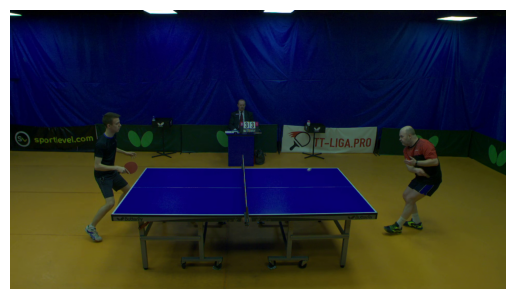

In [9]:
import matplotlib.pyplot as plt
import cv2

# 读取图像
image_path = "/home/aistudio/train_part/game_4/frames/frame_001299.png"
image = cv2.imread(image_path)

# 检查图像是否成功加载
if image is None:
    print(f"Failed to load image: {image_path}")
else:
    # 转换 BGR 到 RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 显示图像
    plt.imshow(image)
    plt.axis("off")  # 关闭坐标轴
    plt.show()

In [5]:
%cd ~
!mkdir -p submission/PaddleDetection/deploy/python
!mkdir -p submission/model
!cp /home/aistudio/PaddleDetection/deploy/python/keypoint_preprocess.py /home/aistudio/submission/PaddleDetection/deploy/python/keypoint_preprocess.py
!cp /home/aistudio/PaddleDetection/deploy/python/preprocess.py /home/aistudio/submission/PaddleDetection/deploy/python/preprocess.py
!cp /home/aistudio/PaddleDetection/deploy/python/utils.py /home/aistudio/submission/PaddleDetection/deploy/python/utils.py
!cp /home/aistudio/predict.py /home/aistudio/submission/predict.py
!touch /home/aistudio/submission/PaddleDetection/deploy/python/__init__.py
!cp -r /home/aistudio/work/export_model/ppyoloe_plus_sod_crn_l_80e_coco/* ~/submission/model/

/home/aistudio


In [6]:
import os

file_path = "/home/aistudio/submission/PaddleDetection/deploy/python/preprocess.py"

def modify_import_statement(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    # 如果某一行包含 "from keypoint_preprocess import get_affine_transform" 则替换为相对导入形式
    modified_lines = [
        line.replace("from keypoint_preprocess import get_affine_transform",
                     "from .keypoint_preprocess import get_affine_transform")
        if "from keypoint_preprocess import get_affine_transform" in line else line
        for line in lines
    ]
    with open(file_path, 'w') as f:
        f.writelines(modified_lines)

modify_import_statement(file_path)


In [9]:
import os

# 指定要搜索的文件夹路径（验证集图片所在目录）
folder_path = "/home/aistudio/work/dataset/val/JPEGImages"
# 指定生成的 txt 文件路径
output_file = "/home/aistudio/submission/output.txt"

# 获取文件夹下所有文件和子文件夹
files = os.listdir(folder_path)
# 打开 txt 文件以写入（覆盖写入）
with open(output_file, "w") as file:
    # 遍历目录中的文件
    for item in files:
        # 如果当前 item 不是子文件夹，则认为是图片文件，写入该文件的完整路径
        if not os.path.isdir(os.path.join(folder_path, item)):
            file.write(os.path.join(folder_path, item) + "\n")


In [2]:
%cd ~/submission
!python3 predict.py output.txt result.json

/home/aistudio/submission
--- Running analysis [ir_graph_build_pass]
I0412 13:03:59.074389  1820 executor.cc:187] Old Executor is Running.
--- Running analysis [ir_analysis_pass]
--- Running IR pass [map_op_to_another_pass]
I0412 13:04:00.592133  1820 fuse_pass_base.cc:59] ---  detected 1 subgraphs
--- Running IR pass [is_test_pass]
--- Running IR pass [simplify_with_basic_ops_pass]
--- Running IR pass [delete_quant_dequant_linear_op_pass]
--- Running IR pass [delete_weight_dequant_linear_op_pass]
--- Running IR pass [constant_folding_pass]
I0412 13:04:00.814922  1820 fuse_pass_base.cc:59] ---  detected 76 subgraphs
--- Running IR pass [silu_fuse_pass]
--- Running IR pass [conv_bn_fuse_pass]
I0412 13:04:00.970925  1820 fuse_pass_base.cc:59] ---  detected 78 subgraphs
--- Running IR pass [conv_eltwiseadd_bn_fuse_pass]
--- Running IR pass [embedding_eltwise_layernorm_fuse_pass]
--- Running IR pass [multihead_matmul_fuse_pass_v2]
--- Running IR pass [vit_attention_fuse_pass]
--- Running I

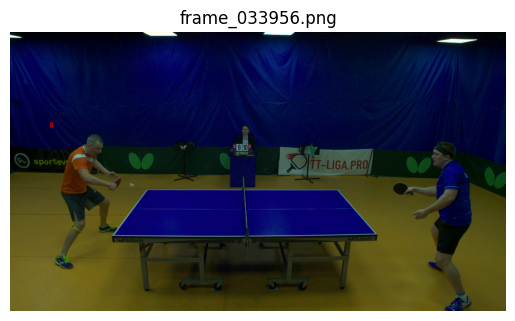

frame_033956.png: (157, 351, 7, 16)


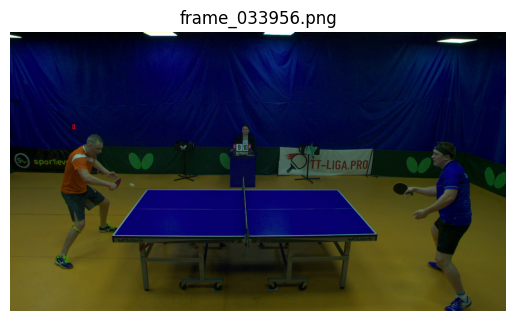

frame_033956.png: (243, 359, 7, 15)


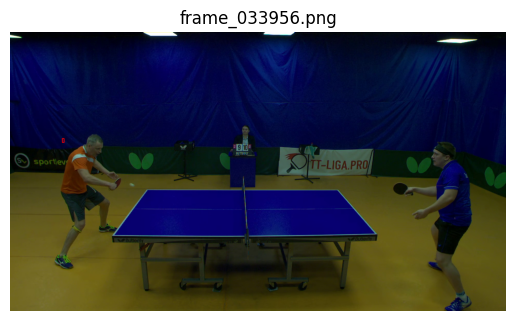

frame_033956.png: (202, 412, 7, 15)


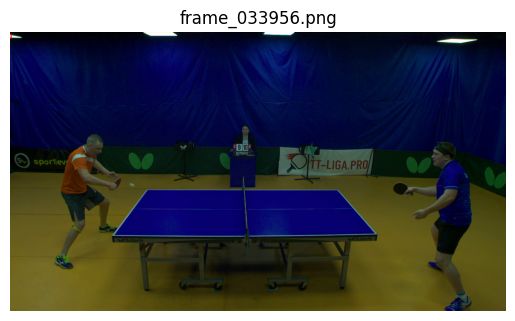

frame_033956.png: (-1, 8, 6, 16)


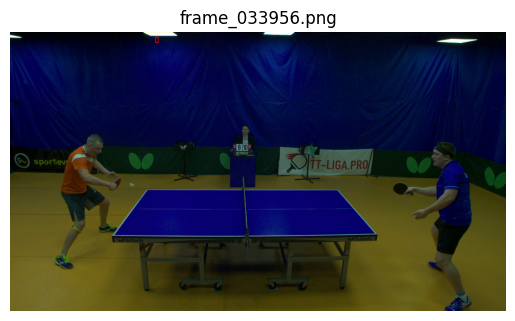

frame_033956.png: (563, 19, 10, 22)


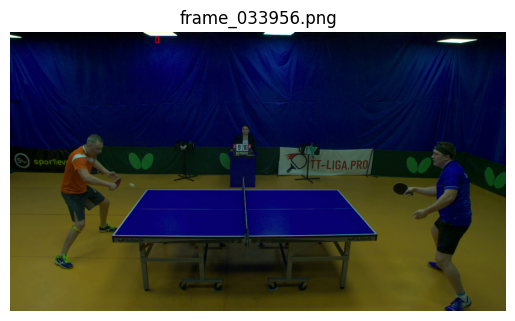

frame_033956.png: (564, 18, 10, 22)


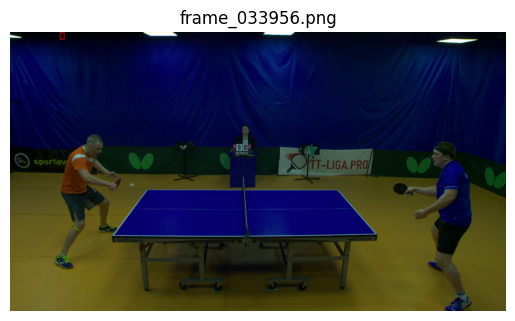

frame_033956.png: (194, 0, 15, 27)


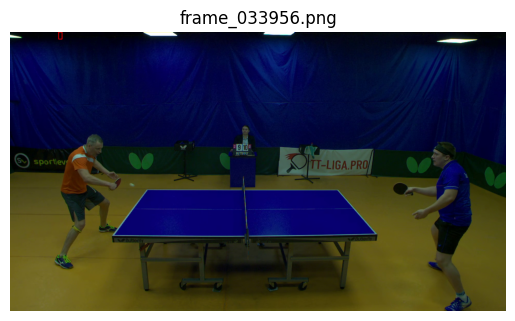

frame_033956.png: (188, 0, 13, 27)


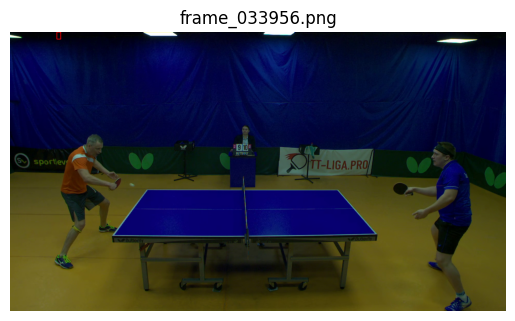

frame_033956.png: (181, 0, 15, 27)


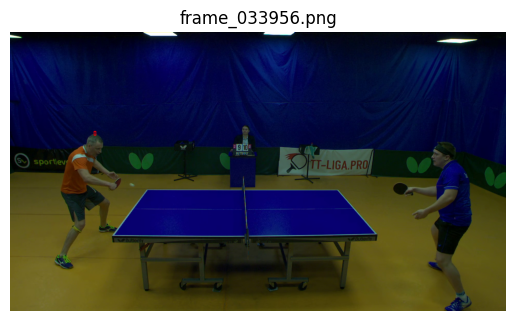

frame_033956.png: (325, 384, 7, 15)


In [14]:
import json
import os
import cv2
import matplotlib.pyplot as plt

def draw_bboxes(json_file, image_folder):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    results = data[:10]  # 取前10个结果查看

    for res in results:
        image_id = res['image_id']
        x, y = int(res['x']), int(res['y'])
        width, height = int(res['width']), int(res['height'])
        
        image_path = os.path.join(image_folder, image_id)
        
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is None:
                print(f"无法读取图片: {image_path}")
                continue

            pt1 = (x, y)
            pt2 = (x + width, y + height)
            cv2.rectangle(image, pt1, pt2, (0, 0, 255), 2)
            
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(image_id)
            plt.axis('off')
            plt.show()
        else:
            print(f"图片不存在: {image_path}")
        print(f"{image_id}: ({x}, {y}, {width}, {height})")


# 使用示例
draw_bboxes("/home/aistudio/submission/result.json", "/home/aistudio/train_part/game_3/frames")


In [6]:
%cd ~/submission
!zip -r submission.zip .
!echo "please download the submission.zip!"

/home/aistudio/submission
  adding: model/ (stored 0%)
  adding: model/.ipynb_checkpoints/ (stored 0%)
  adding: model/.ipynb_checkpoints/infer_cfg-checkpoint.yml (deflated 37%)
  adding: model/model.pdmodel (deflated 91%)
  adding: model/model.pdiparams (deflated 9%)
  adding: model/model.pdiparams.info (deflated 80%)
  adding: model/infer_cfg.yml (deflated 37%)
  adding: predict.py (deflated 62%)
  adding: PaddleDetection/ (stored 0%)
  adding: PaddleDetection/deploy/ (stored 0%)
  adding: PaddleDetection/deploy/python/ (stored 0%)
  adding: PaddleDetection/deploy/python/preprocess.py (deflated 77%)
  adding: PaddleDetection/deploy/python/utils.py (deflated 72%)
  adding: PaddleDetection/deploy/python/__init__.py (stored 0%)
  adding: PaddleDetection/deploy/python/.ipynb_checkpoints/ (stored 0%)
  adding: PaddleDetection/deploy/python/.ipynb_checkpoints/__init__-checkpoint.py (stored 0%)
  adding: PaddleDetection/deploy/python/.ipynb_checkpoints/preprocess-checkpoint.py (deflated 77%

In [ ]:
# 查看工作区文件，该目录下除data目录外的变更将会持久保存。请及时清理不必要的文件，避免加载过慢。
# View personal work directory. 
# All changes, except /data, under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 